In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE             # ↩︎ **NEW** oversampler
from imblearn.pipeline      import Pipeline          # ↩︎ **NEW** imbalanced-learn pipeline
from sklearn.metrics        import roc_auc_score
from sklearn.compose      import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('../data/unusual_drop_preprocess_all_v4.csv')

In [3]:
len(df.columns)

70

In [4]:
with open('../data/selected_cols_v1.txt', 'r', encoding='utf-8') as f:
    selected_cols_v1 = [line.strip() for line in f if line.strip()]

In [5]:
df_sel = df[selected_cols_v1]
df_sel = pd.concat([df_sel, df['int_rate'], df['treasury'], df['loan_status'],df['irr']], axis = 1)

In [7]:
with open('../data/categorical_cols_v1.txt', 'r', encoding='utf-8') as f:
    cat_columns_v1 = [line.strip() for line in f if line.strip() != '']

In [8]:
df_cat = df[cat_columns_v1]
df_cat.head()

,addr_state,inq_last_6mths,emp_length,home_ownership,purpose,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,verification_status,grade
0,OK,1,10+ years,MORTGAGE,debt_consolidation,<1yr,unknown,unknown,<1yr,<1yr,<1yr,0,<1yr,Verified,E
1,TX,0,unknown,MORTGAGE,home_improvement,unknown,unknown,unknown,1-2yr,<1yr,unknown,10+,unknown,Not Verified,A
2,FL,0,5 years,MORTGAGE,home_improvement,unknown,unknown,<3yr,2yr+,1-2yr,unknown,6,unknown,Not Verified,B
3,IL,0,10+ years,MORTGAGE,credit_card,3-4yr,4-5yr,unknown,unknown,1-2yr,3-4yr,5,3-4yr,Source Verified,B
4,NC,1,5 years,MORTGAGE,debt_consolidation,unknown,unknown,unknown,1-2yr,1-2yr,unknown,6,unknown,Verified,D


In [9]:
# 범주형 변수들 -> 원핫인코딩
# columns=cat_columns_v1 (리스트 그대로 전달)
df_cat = pd.get_dummies(df_cat, drop_first=True)

# 원본 컬럼 제거: 이미 get_dummies에서 제거되므로, 보통 이 라인은 필요 없음
# 하지만 혹시 모르니 아래처럼, 변수명을 일치시키세요.
df_cat = df_cat.drop(cat_columns_v1, axis=1, errors='ignore')

In [10]:
df_cat.head()

,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,...,mths_since_recent_revol_delinq_<1yr,mths_since_recent_revol_delinq_unknown,verification_status_Source Verified,verification_status_Verified,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,False,False,False,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,...,False,True,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,True,False,False,False


In [11]:
df_sel = pd.concat([df_sel, df_cat], axis = 1)

In [12]:
# 범주형 변수 남아있는지 체크
obj_cols = df_sel.select_dtypes(include='object').columns
if len(obj_cols) > 0:
    print("아직 문자열 변수 존재:", obj_cols)

In [13]:
# 범주형 변수가 남아있는 게 있는지 확인
obj_cols = df_sel.select_dtypes(include='object').columns
print(obj_cols)

Index([], dtype='object')


In [14]:
# 타겟/입력변수 분리하기
X = df_sel.drop('loan_status', axis=1)
y = df_sel['loan_status']

### 데이터 분할하기

In [15]:
# 3대 1로 train set, validation set 나누기
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
X_tr = X_tr.copy()
X_val = X_val.copy()

In [16]:
# 모델에 제외할 컬럼 
drop_cols = ['irr', 'funded_amnt'] #사후변수

## Decision Tree Model

In [18]:
# (2) 학습/검증 데이터 분리
X_train = X_tr.drop(columns=drop_cols, errors='ignore')
X_valid = X_val.drop(columns=drop_cols, errors='ignore')

# (3) 수치형 / 범주형 컬럼 나누기
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = [c for c in X_train.columns if c not in num_cols]

# (4) 전처리 정의: 수치형은 스케일링, 범주는 그대로
preproc = ColumnTransformer([
    ('num', StandardScaler(with_mean=False), num_cols),
    ('cat', 'passthrough', cat_cols)
])

# (5) 파이프라인 구성: 전처리 → SMOTE → DecisionTree
pipe = Pipeline(steps=[
    ('prep' , preproc),  # 전처리
    ('smote', SMOTE(random_state=2025)),  # 오버샘플링
    ('tree' , DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=3,
        class_weight='balanced',
        random_state=42
    ))
])

# (6) 모델 학습
pipe.fit(X_train, y_tr)

# (7) 검증 세트 예측 및 AUC 출력
val_pred_prob = pipe.predict_proba(X_valid)[:, 1]
print("Validation AUC:", roc_auc_score(y_val, val_pred_prob))

Validation AUC: 0.6839153834365593


### 피처 중요도 추출

In [19]:
# 피처 중요도 추출
model = pipe.named_steps['tree']  # 파이프라인 안의 모델 불러오기

importance = pd.DataFrame(
    model.feature_importances_, 
    index=X_train.columns, 
    columns=["importance"]
)

importance.sort_values(by="importance", ascending=False).head(15)

,importance
int_rate,0.189807
grade_C,0.189034
home_ownership_RENT,0.140659
grade_B,0.123548
purpose_debt_consolidation,0.080682
grade_D,0.049278
mths_since_rcnt_il_unknown,0.045316
addr_state_CA,0.030206
mths_since_recent_bc_<1yr,0.028782
term,0.020409


## 피처 해석: 모델이 부도여부 분류할 때 'grade_D' 신용등급을 가장 많이 참조함!

In [20]:
print(importance.sort_values('importance', ascending=False).head(10))

                            importance
int_rate                      0.189807
grade_C                       0.189034
home_ownership_RENT           0.140659
grade_B                       0.123548
purpose_debt_consolidation    0.080682
grade_D                       0.049278
mths_since_rcnt_il_unknown    0.045316
addr_state_CA                 0.030206
mths_since_recent_bc_<1yr     0.028782
term                          0.020409


### Sharp ratio 계산하기

In [21]:
def calc_sharpe_by_thresholds_stat_econ(model, X_val_model, X_val, y_val, irr_col='irr', treasury_col='treasury'):
    # X_val_model: drop_cols가 이미 적용된 DataFrame
    val_pred_prob = model.predict_proba(X_val_model)[:, 1]
    thresholds = np.linspace(0.01, 0.99, 100)
    sharpe_ratios = []

    for t in thresholds:
        val_binary = np.where(val_pred_prob > t, 1, 0)
        val_return = []
        for pred, actual, irr, treasury in zip(val_binary, y_val, X_val[irr_col], X_val[treasury_col]):
            if pred == 0: # 대출 해줌
                val_return.append(irr)
            else: # 부도 날 거라고 판단해서 대출 안해줌
                val_return.append(treasury - irr)
        val_return = np.array(val_return)
        risk_free = np.array(X_val[treasury_col])
        excess_ret = val_return - risk_free
            
        sharpe = np.mean(excess_ret) / np.std(excess_ret)
        sharpe_ratios.append(sharpe)
    return thresholds, sharpe_ratios

thresholds, sharpe_ratios = calc_sharpe_by_thresholds_stat_econ(
    model=pipe,
    X_val_model=X_valid,  # <- drop된 DataFrame
    X_val=X_val,              # <- 원본(irr, treasury 정보 있음)
    y_val=y_val,
    irr_col='irr',
    treasury_col='treasury'
)

In [22]:
import numpy as np

sharpe_arr = np.array(sharpe_ratios)
threshold_arr = np.array(thresholds)

# NaN 값 제외
valid = ~np.isnan(sharpe_arr)
sharpe_arr_valid = sharpe_arr[valid]
threshold_arr_valid = threshold_arr[valid]

if len(sharpe_arr_valid) > 0:
    idx_max = np.argmax(sharpe_arr_valid)
    max_sharpe = sharpe_arr_valid[idx_max]
    best_threshold = threshold_arr_valid[idx_max]
    print(f"Sharpe ratio가 극대화되는 threshold: {best_threshold:.4f}")
    print(f"최대 Sharpe ratio 값: {max_sharpe:.4f}")
else:
    print("유효한 Sharpe ratio 값이 없습니다.")

Sharpe ratio가 극대화되는 threshold: 0.5148
최대 Sharpe ratio 값: 0.0875


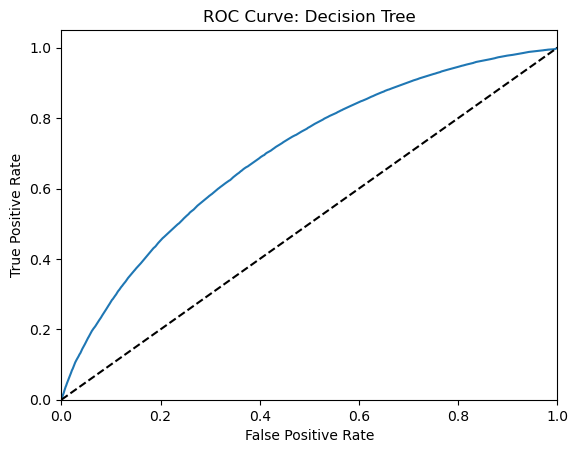

In [66]:
# 예측 확률 가져오기 (두 번째 열이 1일 확률)
y_val_proba = lpm.predict_proba(X_val)[:, 1]

# ROC 커브 계산
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)

# ROC 커브 시각화
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')  # 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Decision Tree')
plt.show()


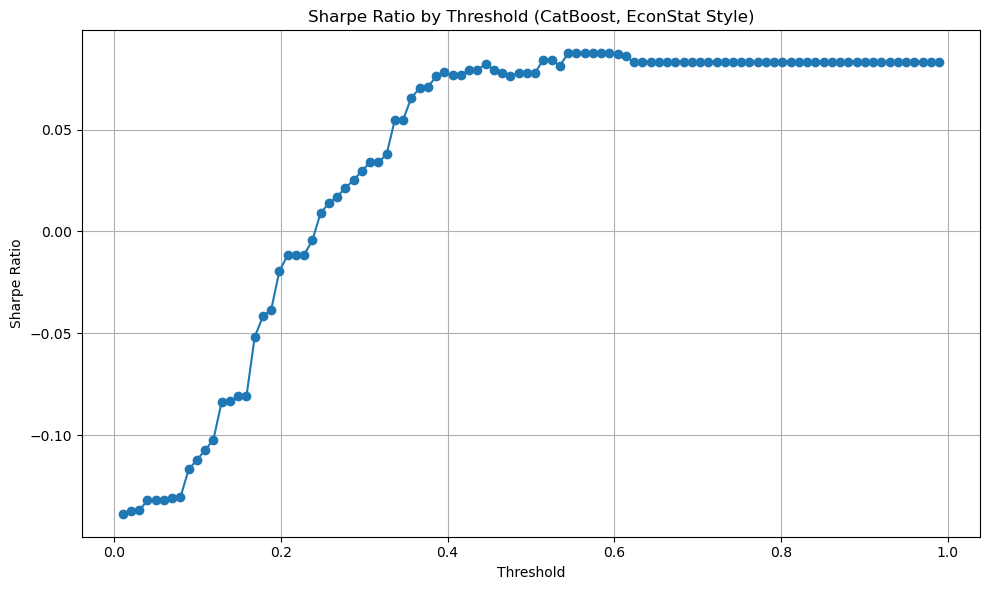

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, sharpe_ratios, marker='o')
plt.xlabel("Threshold")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio by Threshold (CatBoost, EconStat Style)")
plt.grid(True)
plt.tight_layout()
plt.show()

## 모델 분류 성능 : 0.6992

In [67]:
from sklearn.metrics import auc

roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

AUC: 0.6976


## J-score로 Optimal Threshold 찾기

### 목적) ROC 커브에서 가장 "왼쪽 위"에 있는 지점 찾기
### True Positive는 높고, False Positive는 낮은 구간
### 이 임계값은 이후 predict_proba > threshold로 이진 예측 기준선으로 사용 가능

In [68]:
# 목적: TPR - FPR이 가장 큰 임계값 = 가장 "이득이 큰 지점" (J-score 최대)
from sklearn.metrics import roc_curve

y_val_proba = lpm.predict_proba(X_val)[:, 1]  # 확률값 예측
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)

j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.4f}")

Optimal threshold: 0.5037


## Sharpe Ratio계산

In [69]:
thresholds = np.linspace(0.01, 0.99, 100)
sharpe_ratios = []

for t in thresholds:
    val_binary = (y_val_proba > t).astype(int)  # 확률값 기반 분류 결과
    val_return = []

    for pred, actual, r, rf in zip(val_binary, y_val, X_val['int_rate'], X_val['treasury']):
        if pred == 0:  # 대출 승인
            if actual == 1:  # 부도
                val_return.append(0)
            else:  # 정상 상환
                val_return.append(r)
        else:  # 대출 거절
            val_return.append(rf)

    val_return = np.array(val_return)
    excess_ret = val_return - X_val['treasury'].values
    sharpe = excess_ret.mean() / excess_ret.std()
    sharpe_ratios.append(sharpe)


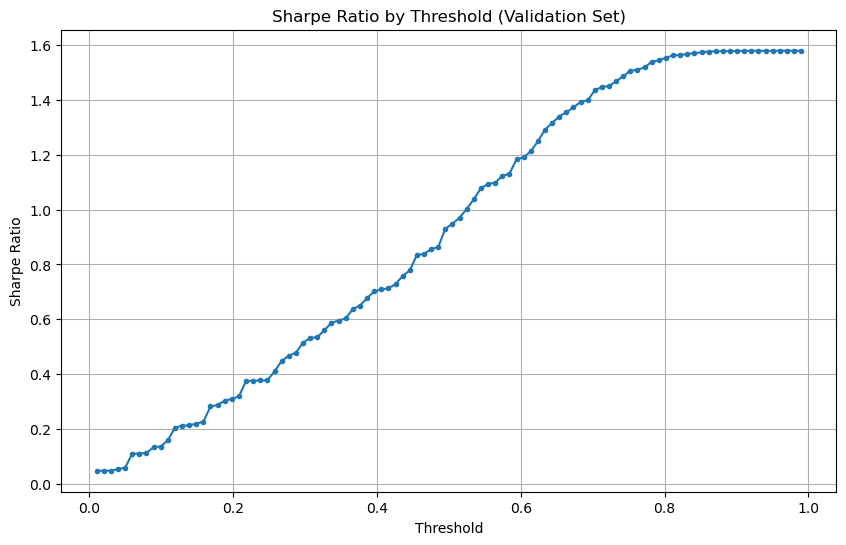

 Optimal Threshold: 0.970
 Max Sharpe Ratio: 1.5794


In [70]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, sharpe_ratios, marker='o', markersize=3)
plt.xlabel("Threshold")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio by Threshold (Validation Set)")
plt.grid(True)
plt.show()

optimal_idx = np.nanargmax(sharpe_ratios)
optimal_threshold = thresholds[optimal_idx]
print(f" Optimal Threshold: {optimal_threshold:.3f}")
print(f" Max Sharpe Ratio: {sharpe_ratios[optimal_idx]:.4f}")


## Sharpe Ratio 최적 임계값 탐색하기

Max Sharpe Ratio: 1.5794, at threshold = 0.970


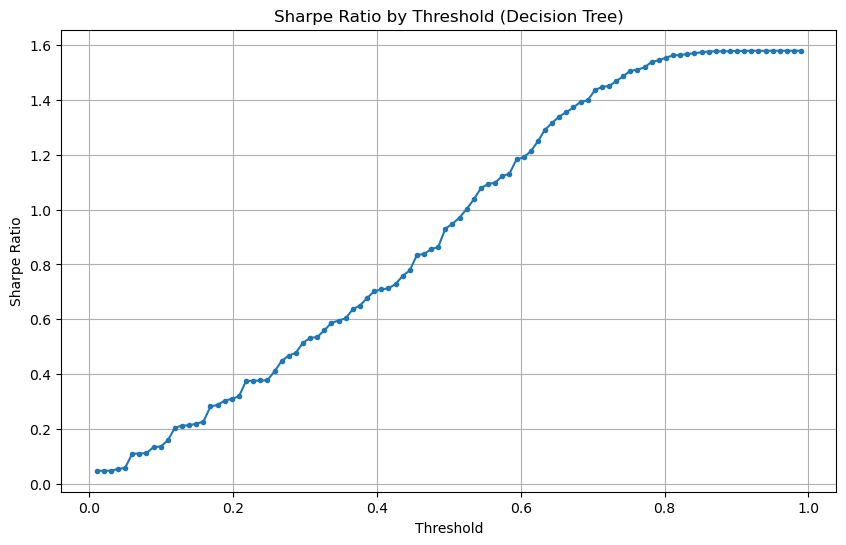

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# 예측 확률 준비 (1일 확률)
val_pred_prob = lpm.predict_proba(X_val)[:, 1]

# threshold 범위 설정
thresholds = np.linspace(0.01, 0.99, 100)

# 기본 정보
n_sample = len(X_val)
n_thresholds = len(thresholds)

# 2D 확률 매트릭스 생성
val_pred_matrix = val_pred_prob.reshape(-1, 1)
val_binary_mat = (val_pred_matrix > thresholds.reshape(1, -1)).astype(int)

# 실제값, 이자율, 무위험수익률(=treasury) 가져오기
y_val_mat = np.tile(np.array(y_val).reshape(-1, 1), (1, n_thresholds))
int_rate_mat = np.tile(np.array(X_val['int_rate']).reshape(-1, 1), (1, n_thresholds))
treasury_mat = np.tile(np.array(X_val['treasury']).reshape(-1, 1), (1, n_thresholds))

# 조건 설정
cond_lend = (val_binary_mat == 0)  # 대출함
cond_good = (y_val_mat == 0)       # 부도 아님 (정상상환)

good_lend = cond_lend & cond_good  # 대출 + 정상상환
bad_lend = cond_lend & ~cond_good  # 대출 + 부도
not_lend = (val_binary_mat == 1)   # 대출 거절

# 수익률 매트릭스 계산
val_return_mat = np.zeros_like(val_binary_mat, dtype=float)
val_return_mat[good_lend] = int_rate_mat[good_lend]
val_return_mat[bad_lend] = 0
val_return_mat[not_lend] = treasury_mat[not_lend]

# 초과 수익률 및 Sharpe Ratio 계산
excess_ret_mat = val_return_mat - treasury_mat
means = np.mean(excess_ret_mat, axis=0)
stds = np.std(excess_ret_mat, axis=0)
sharpe_ratios = np.where(stds > 0, means / stds, np.nan)

# 최적 threshold 찾기
optimal_idx = np.nanargmax(sharpe_ratios)
optimal_threshold = thresholds[optimal_idx]
max_sharpe = sharpe_ratios[optimal_idx]

print(f"Max Sharpe Ratio: {max_sharpe:.4f}, at threshold = {optimal_threshold:.3f}")

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, sharpe_ratios, marker='o', markersize=3)
plt.xlabel("Threshold")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio by Threshold (Decision Tree)")
plt.grid(True)
plt.show()


## Validation data set에서 테스트하기

In [72]:
from sklearn.tree import DecisionTreeClassifier

# 전체 데이터를 이용한 최종 학습
lpm = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    class_weight='balanced'
)

lpm.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=3, min_samples_split=5)

In [73]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

N_BOOTSTRAP = 100  # ← 부트스트랩 횟수 100으로 수정
thresholds = np.linspace(0.01, 0.99, 100)

def calc_max_sharpe(seed):
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=seed)
    X_tr = X_tr.copy()
    X_val = X_val.copy()

    # Decision Tree 분류 모델 학습
    lpm = DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=3,
        class_weight='balanced'
    )
    lpm.fit(X_tr, y_tr)
    val_pred_prob = lpm.predict_proba(X_val)[:, 1]  # 확률값 (class 1일 확률)

    # 수익률 계산 준비
    n_val = len(X_val)
    n_thresh = len(thresholds)
    val_pred_matrix = val_pred_prob.reshape(-1, 1)
    val_binary_mat = (val_pred_matrix > thresholds.reshape(1, -1)).astype(int)

    y_val_mat = np.array(y_val).reshape(-1, 1)
    int_rate_mat = np.array(X_val['int_rate']).reshape(-1, 1)
    treasury_mat = np.array(X_val['treasury']).reshape(-1, 1)

    y_val_mat = np.tile(y_val_mat, (1, n_thresh))
    int_rate_mat = np.tile(int_rate_mat, (1, n_thresh))
    treasury_mat = np.tile(treasury_mat, (1, n_thresh))

    cond_lend = (val_binary_mat == 0)
    cond_good = (y_val_mat == 0)
    good_lend = cond_lend & cond_good
    bad_lend = cond_lend & ~cond_good
    not_lend = (val_binary_mat == 1)

    val_return_mat = np.zeros_like(val_binary_mat, dtype=float)
    val_return_mat[good_lend] = int_rate_mat[good_lend]
    val_return_mat[bad_lend] = 0
    val_return_mat[not_lend] = treasury_mat[not_lend]

    excess_ret_mat = val_return_mat - treasury_mat
    means = np.mean(excess_ret_mat, axis=0)
    stds = np.std(excess_ret_mat, axis=0)
    sharpe_ratios = np.where(stds > 0, means / stds, np.nan)

    max_sharpe = np.nanmax(sharpe_ratios)
    return max_sharpe

# 병렬 실행
sharpe_dist = Parallel(n_jobs=7)(delayed(calc_max_sharpe)(seed) for seed in range(N_BOOTSTRAP))

# 시각화 및 통계
plt.figure(figsize=(10, 6))
plt.hist(sharpe_dist, bins=30, edgecolor='k', alpha=1)
plt.xlabel("Max Sharpe Ratio (per split)")
plt.ylabel("Frequency")
plt.title("Sharpe Ratio Distribution via Random Splits (n=100)")
plt.grid(True)
plt.show()

print(f"평균 Sharpe Ratio: {np.nanmean(sharpe_dist):.4f}")
print(f"최대 Sharpe Ratio: {np.nanmax(sharpe_dist):.4f}")
print(f"최소 Sharpe Ratio: {np.nanmin(sharpe_dist):.4f}")
print(f"중앙값 Sharpe Ratio: {np.nanmedian(sharpe_dist):.4f}")
print(f"표준편차 Sharpe Ratio: {np.nanstd(sharpe_dist):.4f}")


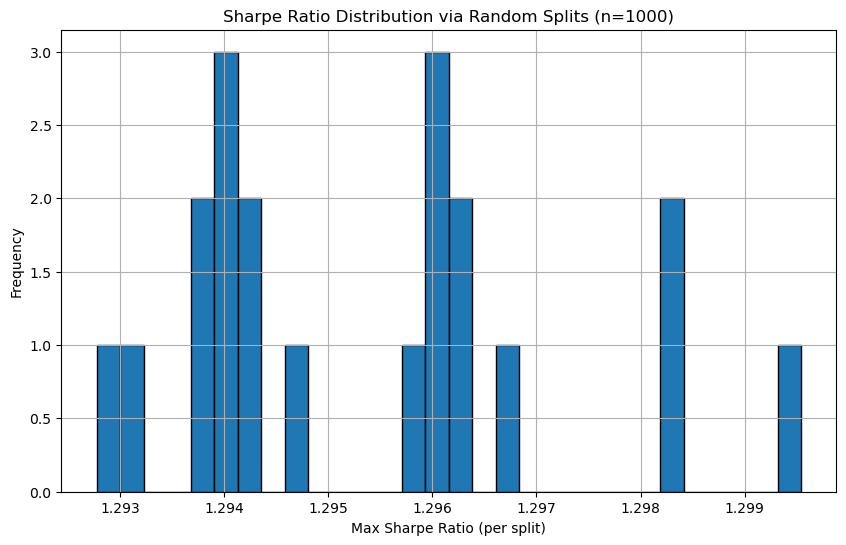

평균 Sharpe Ratio: 1.2954
최대 Sharpe Ratio: 1.2995
최소 Sharpe Ratio: 1.2928
중앙값 Sharpe Ratio: 1.2953
표준편차 Sharpe Ratio: 0.0018


In [45]:
# 벡터화 방식 샤프레이시오 부트스트레핑 (위의 병렬화 방식과 결과는 동일)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

N_BOOTSTRAP = 20
sharpe_dist = []
thresholds = np.linspace(0.01, 0.99, 100)

for seed in range(N_BOOTSTRAP):
    # 3:1 split, random_state만 다르게!
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=seed)
    
    X_tr = X_tr.copy()
    X_val = X_val.copy()
    X_tr['risk_free'] = 3
    X_val['risk_free'] = 3

    lpm = LinearRegression()
    lpm.fit(X_tr.drop(columns='risk_free'), y_tr)
    val_pred_prob = lpm.predict(X_val.drop(columns='risk_free'))  # (n_val, )

    # ==== [ 벡터화 구간 ] ====
    n_val = len(X_val)
    n_thresh = len(thresholds)
    # (n_val, 1)
    val_pred_matrix = val_pred_prob.reshape(-1, 1)
    val_binary_mat = (val_pred_matrix > thresholds.reshape(1, -1)).astype(int)  # (n_val, n_thresh)

    # (n_val, 1) → (n_val, n_thresh)로 확장
    y_val_mat = np.array(y_val).reshape(-1, 1)
    int_rate_mat = np.array(X_val['int_rate']).reshape(-1, 1)
    risk_free_mat = np.array(X_val['risk_free']).reshape(-1, 1)

    y_val_mat = np.tile(y_val_mat, (1, n_thresh))
    int_rate_mat = np.tile(int_rate_mat, (1, n_thresh))
    risk_free_mat = np.tile(risk_free_mat, (1, n_thresh))

    cond_lend = (val_binary_mat == 0)
    cond_good = (y_val_mat == 0)
    good_lend = cond_lend & cond_good
    bad_lend = cond_lend & ~cond_good
    not_lend = (val_binary_mat == 1)

    val_return_mat = np.zeros_like(val_binary_mat, dtype=float)
    val_return_mat[good_lend] = int_rate_mat[good_lend]
    val_return_mat[bad_lend] = 0
    val_return_mat[not_lend] = risk_free_mat[not_lend]

    excess_ret_mat = val_return_mat - risk_free_mat
    means = np.mean(excess_ret_mat, axis=0)
    stds = np.std(excess_ret_mat, axis=0)
    sharpe_ratios = np.where(stds > 0, means / stds, np.nan)

    # max Sharpe만 저장
    max_sharpe = np.nanmax(sharpe_ratios)
    sharpe_dist.append(max_sharpe)

# 히스토그램 시각화
plt.figure(figsize=(10,6))
plt.hist(sharpe_dist, bins=30, edgecolor='k', alpha=1)
plt.xlabel("Max Sharpe Ratio (per split)")
plt.ylabel("Frequency")
plt.title("Sharpe Ratio Distribution via Random Splits (n=1000)")
plt.grid(True)
plt.show()

# 통계값 출력
print(f"평균 Sharpe Ratio: {np.nanmean(sharpe_dist):.4f}")
print(f"최대 Sharpe Ratio: {np.nanmax(sharpe_dist):.4f}")
print(f"최소 Sharpe Ratio: {np.nanmin(sharpe_dist):.4f}")
print(f"중앙값 Sharpe Ratio: {np.nanmedian(sharpe_dist):.4f}")
print(f"표준편차 Sharpe Ratio: {np.nanstd(sharpe_dist):.4f}")
